In [1]:
import re
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import shutil

#This jupyter notebook extracts the potential energy prediction from a LAMMPS
#  single-point calculation driven by an ensemble of neural network (NN) potentials. 

#This calculation is done on a list of new structures. If the potential energy 
#  predictions from the current NN generation has standard deviation exceeding 
#  0.0025 eV/atom, these structures are most likely in regions of the phase space
#  not covered by previous training

# Structures are then extracted in a new folder to be included
#  in the training set for a subsequent NN generation.

In [2]:
folder_nn_1 = 'nn_1_out'
folder_nn_2 = 'nn_2_out'
folder_nn_3 = 'nn_3_out'
folder_nn_4 = 'nn_4_out'
folder_nn_5 = 'nn_5_out'


In [17]:
def make_e_array(folder):
    
    %cd /Users/pedrogm/Desktop/Berkeley/olsalz-project/phase-II-potential-training/outputs

    %cd {folder}
    current_directory = os.getcwd()

    struct_array = []
    atoms_number = []
    pot_energy = []
    
    #Find files .out
    for filename in os.listdir(current_directory):
        if filename[-4:] == '.out':
            #Get Structure Name
            struct_array.append(filename[:-4])
            with open(filename, 'r') as f:
                target_index = -99
                done = 0
                #Go through all lines of output file
                for i, line in enumerate(f):
                    if done == 0:
                        #Find # of atoms to calculate atomic E
                        match_num = re.search(r"(\d+) atoms", line)
                        if match_num:
                            num_atoms = int(match_num.group(1))
                            atoms_number.append(num_atoms)
                            done = 1
                    
                    #Find Potential Energy
                    if i == target_index + 1:
                        pattern = r'-?\d+(?:\.\d+)?'
                        match = re.findall(pattern, line)
                        pot_energy.append(float(match[3]))
                    
                    #Find beggining of with potential energy
                    if str(line.split(" ")[0]) == "Step":
                        target_index = i

    #Sort things properly so the structures are in order, and sort pot. energy and # of atoms array
    sorted_indices = sorted(range(len(struct_array)), key=lambda k: struct_array[k])
    struct_array = [struct_array[i] for i in sorted_indices]
    pot_energy = [pot_energy[i] for i in sorted_indices]
    atoms_number = [atoms_number[i] for i in sorted_indices]
    
    return [np.asarray(struct_array), np.asarray(pot_energy), np.asarray(atoms_number)]
            
        

In [18]:
nn_1 = make_e_array(folder_nn_1)
nn_2 = make_e_array(folder_nn_2)
nn_3 = make_e_array(folder_nn_3)
nn_4 = make_e_array(folder_nn_4)
nn_5 = make_e_array(folder_nn_5)

/Users/pedrogm/Desktop/Berkeley/olsalz-project/phase-II-potential-training/outputs
/Users/pedrogm/Desktop/Berkeley/olsalz-project/phase-II-potential-training/outputs/nn_1_out
/Users/pedrogm/Desktop/Berkeley/olsalz-project/phase-II-potential-training/outputs
/Users/pedrogm/Desktop/Berkeley/olsalz-project/phase-II-potential-training/outputs/nn_2_out
/Users/pedrogm/Desktop/Berkeley/olsalz-project/phase-II-potential-training/outputs
/Users/pedrogm/Desktop/Berkeley/olsalz-project/phase-II-potential-training/outputs/nn_3_out
/Users/pedrogm/Desktop/Berkeley/olsalz-project/phase-II-potential-training/outputs
/Users/pedrogm/Desktop/Berkeley/olsalz-project/phase-II-potential-training/outputs/nn_4_out
/Users/pedrogm/Desktop/Berkeley/olsalz-project/phase-II-potential-training/outputs
/Users/pedrogm/Desktop/Berkeley/olsalz-project/phase-II-potential-training/outputs/nn_5_out


In [9]:
#Create array with the stdev of each structure accross ensemble

e_etomic_nn_1 = nn_1[1] / nn_1[2]
e_etomic_nn_2 = nn_2[1] / nn_2[2]
e_etomic_nn_3 = nn_3[1] / nn_3[2]
e_etomic_nn_4 = nn_4[1] / nn_4[2]
e_etomic_nn_5 = nn_5[1] / nn_5[2]

avg = (
    e_etomic_nn_1 + 
    e_etomic_nn_2 + 
    e_etomic_nn_3 + 
    e_etomic_nn_4 + 
    e_etomic_nn_4  
        )/5


stdev = ((
    (e_etomic_nn_1 - avg)**2 + 
    (e_etomic_nn_2 - avg)**2 + 
    (e_etomic_nn_3 - avg)**2 + 
    (e_etomic_nn_4 - avg)**2 + 
    (e_etomic_nn_5 - avg)**2
        )/5)**(1/2)



In [11]:
#Extract list of configurations with stdev above threshold e

e = 0.0025
indices = np.where(stdev > e)
structures = np.take(nn_1[1], indices)



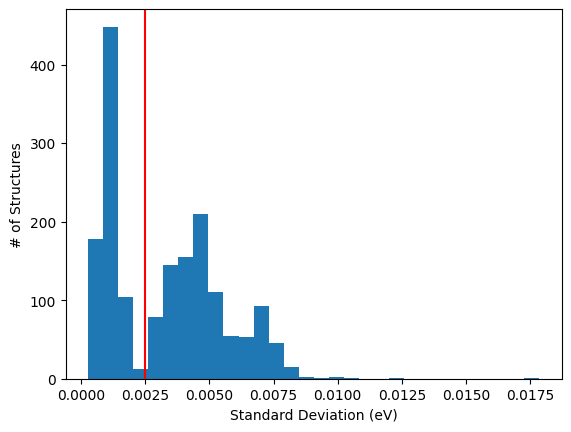

In [12]:
plt.hist(stdev, density=True, bins=30)  # density=False would make counts
plt.axvline(x = 0.0025, color='red')
plt.ylabel('# of Structures')
plt.xlabel('Standard Deviation (eV)');


In [ ]:
#Add the .lammps extension 

final_list_inputs = []
for i in range(len(structures[0])):
    final_list_inputs.append(structures[0][i] + ".lammps")

In [ ]:
%cd /Users/pedrogm/Desktop/Research/dmpn-project/low_t_MD/struct/all_structures


for file in final_list_inputs:
    # get full path of source file
    source_file = os.path.abspath(file)
    
    # construct full path of target file
    target_file = '/Users/pedrogm/Desktop/Research/dmpn-project/low_t_MD/struct/qe_structures/' + file

    # copy file to target directory
    shutil.copy2(source_file, target_file)

